# 데이터 선정 이유 및 문제 정의
- 사용한 데이터셋: [JantaHack: Cross sell Prediction](https://www.kaggle.com/pawan2905/jantahack-cross-sell-prediction)
- 컬럼 구성
1. `id` - Unique ID for the customer
2. `Gender`- Gender of the customer
3. `Age` - Age of the customer
4. `Driving*License` -  0 : 면허 없음, 1 : 면허 있음.* 
5. `RegionCode` -  Unique code for the region of the customer
6. `Previously *Insured` - 1 : 이미 Vehicle Insurance 있음, 0 : 없음* 
7. `VehicleAge` -  Age of the Vehicle
8. `VehicleDamage` -  1 : 과거 vehichle 사고이력 있음.  0 : 없음.* 
9. `AnnualPremium` -  The amount customer needs to pay as premium in the year
10. `PolicySalesChannel` 
    - Anonymised Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc. (= 고객에게 접근한 채널의 분류 코드)
11. `Vintage` - Number of Days, 고객이 회사와 얼마나 함께 했는지
12. `Response` ⭐ -  1 : Customer is interested, 0 : Customer is not interested**

---
**데이터 불러오기**

In [2]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Insurance Engage Prediction/train.csv')
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [3]:
df.shape # 20% 테스트 데이터로 빼도 대충 30만개는 훈련/검증 데이터에 사용할 수 있겠다. 이 정도면 좋은 거 같다. 

(381109, 12)

**지금 미리 훈련/테스트 데이터 나눠두자**
- 안 그럼 탐색 과정에서 Data Leakage로 이어질 수도?!
- 왜냐면 데이터 탐색하며 여러 가설을 세우게 될텐데, 그때 테스트 셋의 정보까지 들어가면.. 그게 누수아닌가?!

In [4]:
#split 'df' into 'train' and 'test' dataset
from sklearn.model_selection import train_test_split

target = 'Response' #후에 타겟 변경 시, 변경 후 재실행 필요함. 

train, test = train_test_split(df, stratify = df[target], random_state = 42) # stratify를 target에 맞추어서! 

train.shape, test.shape

((285831, 12), (95278, 12))

**데이터 간단 탐색 - Pandas Profiling**

In [5]:
#!pip install -U pandas-profiling

In [6]:
#!pip install --user --upgrade aws-sam-cli #pandas_profiling import error나서 추가 설치하는 것임.

In [7]:
#import pandas_profiling

#profile = df.profile_report() #이미 보았으니 주석처리 해둠.
#profile

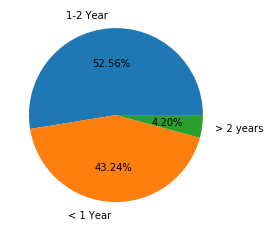

In [8]:
import matplotlib.pyplot as plt

# create data: an array of values
names = '1-2 Year', '< 1 Year', '> 2 years'
size_of_groups=[200316, 164786, 16007]

# Create a pieplot
plt.pie(size_of_groups, autopct="%.2f%%", labels = names, labeldistance=1.15);
plt.show()


- Missing Values, Duplicated Rows 없음.
- Driving License 거의 대부분 다 있음. 없는 고객은 600명 밖에 안됨. 이 사람들은 대상에서 아예 빼버려도 될 수도 있겠다?
- Region_Code 특정 지역이 많이 보인다.  / Policy_Sales_Channel도 특정 3개 채널이 압도적임. 참고. 
- 이미 vehicle 보험 있는 사람도 상당히 많이 있네. (반반 정도?) 이 사람들 어떻게 대답했을지 궁금하다. 
- Response는 0이 훨씬 많은데, 이건 보통 광고 특성 상 당연함. 이따 다시 분포 살펴보겠지만 반드시 기억해둘 것. ⭐
- `High correlation`한 특성이 많다고 alert 주고 있는데, 참고!!! ⭐

**⭐⭐ 시나리오와 풀고 싶은 문제를 내 언어로 정의해보자!! ⭐⭐**

1. 시나리오 (= 이 프로젝트를 진행하게된 가상의 상황을 정의한다)
    - 회사는 현재 **건강 보험**을 주력 상품으로 제공하고 있는데, 이제는 수익성 강화를 위해 **자동차 보험**을 새롭게 선보이고자 한다. 회사는 자동차 보험을 출시하기에 앞서 기존 고객이 자동차 보험에도 추가로 가입할 의사가 있는지를 예측하고, 의사가 있는 고객을 대상으로 런칭 프로모션을 진행하는 등의 빠른 시장 진출 전략을 수립할 것이다.
2. 어떤 문제를 풀고 싶은가?
    - 기존에 건강 보험에 가입해 이용하고 있는 고객들 중, 새롭게 출시할 자동차 보험에도 가입할 의사가 있는 고객을 예측한다.
3. 회귀 문제인가? 분류 문제인가?
    - 분류 문제이다.
4. 어떤 컬럼을 타겟으로 잡을 것인가?
    - `Response` - 기존 고객 중, 자동차 보험에 가입할 의사가 있는지 여부를 나타내는 컬럼이다.
    

**타겟 예측 관련 어떤 가설을 세울 수 있는가?** (예. 00이 타겟에 영향을 많이 줄 것 같다. / 여러 시각화 해보자!)

- 운전면허가 없는 고객의 대다수는 자동차 보험에 관심이 없을 것이다.
- 나이가 어릴수록 자동차 보험 가입에 관심이 없을 것이다.
    - 보험료를 감당할 수 있는가? 운전에 대한 근거 없는 자신감?
- 연식이 오래되었을 수록 관심이 없을 것이다.
    - 이게 맞다면 이런 질문도 의미O ⇒ 나이가 어릴 수록 자동차 연식이 오래된 걸 탈 것이다.
- 성별과 관심도의 차이는 없을 것이다.
- 이미 자동차 보험에 가입한 고객은 우리 회사의 자동차 보험 가입에 관심이 없을 것이다.
- 이전에 자동차 파손이 있었던 고객은 보험 가입에 관심이 있을 것이다.
- 연간 보험료가 낮을수록 가입에 관심이 많을 것이다.
- 세일즈 채널과 관심도의 차이는 없을 것이다.
- 고객이 우리 회사와 오래 했을 수록 관심이 많을 것이다.

일단 각 피쳐 단독으로 타겟과의 관계를 추정했을 때 이 정도 나오는 것 같고, 보다 더 한 것은 2단계에서 EDA하면서 좀 더 살펴보자.

--

- High Correlation Alert 참고
    - Age ↔ Policy_Sales_Channel
    - Previously_Insured ↔ Vehicle_Damage
    - Repsonse ↔ Previously_Insured


# 2. 데이터 전처리, EDA, 시각화, Feature Engineering

## 데이터셋 확인 - Type, Missing Values, outliers
- 이건 train, test 따로 볼 것이 아니라 df로 한 번에 보고 필요한 처리만 적절히 해주면 될 듯.
- 아까 train 으로만 프로파일링 해봤는데, df로도 해보고, 거기 나오는 시각화면 굳이 코드 반복 하지 말자.

In [9]:
#Missing Values
print(df.isnull().sum()) #결측치 없다. 

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64


In [10]:
#data type 적절한지?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [11]:
#카테고리 타입 컬럼 unique 확인
print(df.Vehicle_Age.unique(),'\n')
print(df.Region_Code.unique(), '\n')
print(df.Policy_Sales_Channel.unique())

['> 2 Years' '1-2 Year' '< 1 Year'] 

[28.  3. 11. 41. 33.  6. 35. 50. 15. 45.  8. 36. 30. 26. 16. 47. 48. 19.
 39. 23. 37.  5. 17.  2.  7. 29. 46. 27. 25. 13. 18. 20. 49. 22. 44.  0.
  9. 31. 12. 34. 21. 10. 14. 38. 24. 40. 43. 32.  4. 51. 42.  1. 52.] 

[ 26. 152. 160. 124.  14.  13.  30. 156. 163. 157. 122.  19.  22.  15.
 154.  16.  52. 155.  11. 151. 125.  25.  61.   1.  86.  31. 150.  23.
  60.  21. 121.   3. 139.  12.  29.  55.   7.  47. 127. 153.  78. 158.
  89.  32.   8.  10. 120.  65.   4.  42.  83. 136.  24.  18.  56.  48.
 106.  54.  93. 116.  91.  45.   9. 145. 147.  44. 109.  37. 140. 107.
 128. 131. 114. 118. 159. 119. 105. 135.  62. 138. 129.  88.  92. 111.
 113.  73.  36.  28.  35.  59.  53. 148. 133. 108.  64.  39.  94. 132.
  46.  81. 103.  90.  51.  27. 146.  63.  96.  40.  66. 100.  95. 123.
  98.  75.  69. 130. 134.  49.  97.  38.  17. 110.  80.  71. 117.  58.
  20.  76. 104.  87.  84. 137. 126.  68.  67. 101. 115.  57.  82.  79.
 112.  99.  70.   2.  34.  33.  74

In [12]:
#df 프로파일링 - 이상치 확인이 주된 목적임
#profile_df = df.profile_report() 이미 봤으니 주석처리 해둠
#profile_df

- `Driving Lisense` - 전에 봤던 것처럼 812명만 없고 380297명은 면허가 있다.
    - 엄밀히 말하면 812명이 ‘이상치’라고 말하기는 어렵지만, 우리의 목적을 생각해봤을 때 굳이 필요한가? 싶기는 하다.
- `Region_Code` - 이렇게 특정 지역이 대부분인데 이게 나중에 학습에 어떤 영향을 줄까? 는 지금은 모르겠다.
  - **`Policy_Sales_Channel` -** 같은 맥락에서 이것도 마찬가지. 파워풀한 채널은 대게 정해져있으니까 특정 채널로 쏠림은 당연한거긴 하다는 점에서 이상치로 보기는 어렵지만, 나중에 해당 특성을 잘 살펴보면 좋을 듯.
- 그 외 이상치로 볼만한 특이사항은 없다.

---
**Target Leakage Check**
- Target Leakage란 학습하는 시점에 알 수 없는 특성이 데이터셋에 포함되는 것을 말한다.
    - 예를 들어, 암 발생 여부를 예측하고자 사용하는 데이터셋에서 `항암치료 여부` 라는 특성이 들어가 있다면? 이건 암으로 실제 진단받은 ‘이후의’ 정보를 담고 있는 특성일 확률이 매우 높다. 암 진단을 받은 환자만 항암치료를 받게 될 것이니, 만약 이 특성을 제거해주지 않는다면 모델은 지나치게 낙관적인 예측을 하게 될 것이다.
- 이런 정보가 지금 내가 사용하는 데이터셋에 있는가?
    - 아까 Profiling 했을 때 타겟과 관련된 Highly Correlation Alert은 다음이 있었다.
        - `Response` is highly correlated with `Previously_Insured`and 1 other fields.
        - `Previously_Insured` is highly correlated with `Vehicle_Damage`.
    - 이 특성들이 Target Leakage라고 볼 수 있는가? **아닌 것 같다.**
        - 이미 자동차보험에 가입했는지, 이전에 자동차 파손 경험이 있는지는 모두 우리의 타겟인 ‘우리 회사의 신규 자동차 보험 가입에 관심이 있는가?’를 묻는 시점 이전에 일어난 일이기 때문이다.
    - 단순히 highly Correaltion을 가지고 있다고 해서 모두 누수라고 판단할 필요는 없다는 걸 기억해야할 것 같다. 사실 엄청 좋은 특성인데 무심코 제거해버리는 실수를 할 수도 있을 것 같다.
    
    물론 아직 모델링해보기 전이기 때문에, 아직까지는 위 내 생각도 의견인걸로~~
    

(타겟 누수 관련 다음 블로그를 참고함. [https://m.blog.naver.com/hongjg3229/221811766581](https://m.blog.naver.com/hongjg3229/221811766581))

## 타겟 분포 확인 / 가설 확인 / 시각화 ⭐⭐⭐⭐

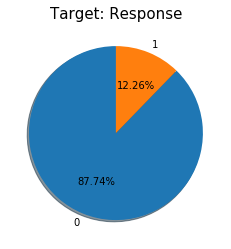

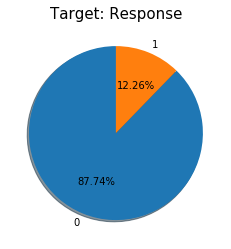

In [13]:
### 타겟 클래스 분포 확인 ###
import matplotlib.pyplot as plt

def analysis_on_target(df):
    n_zero_label = df['Response'][(df['Response'] == 0)].count()
    n_one_label = df['Response'][(df['Response'] == 1)].count()

    plt.pie(
        (n_zero_label, n_one_label),
        labels=(0, 1),
        autopct="%.2f%%",
        shadow=True,
        startangle=90,
    )
    plt.title("Target: Response", size=15)
    plt.show()

    return n_zero_label, n_one_label

train_label_count = analysis_on_target(train)
test_label_count = analysis_on_target(test) 

**모델링할 때 class_weight 신경 써야겠다.**

아까 프로파일 리포트에서 봤을 때 `Response`가 `Previously_Insured` , `Vehicle_Damage`와 큰 연관이 있다고 했다. 진짜 그럴까?  

                        Response = 0  Response = 1
Previously_Insured = 0        119919         34918
Previously_Insured = 1        130880           114


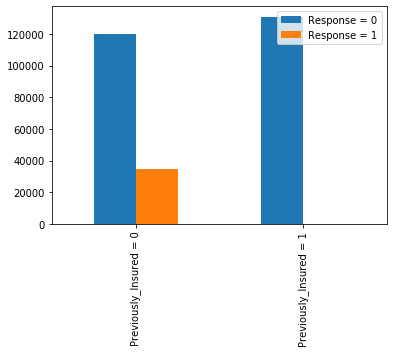

In [14]:
# Response & Previously_Insured
##plt.bar(train['Previously_Insured'], train['Response']) #왜케 실행하는데 오래 걸리지? 방법을 바꿔서 해야겠다.

a = pd.DataFrame([[train[(train['Previously_Insured'] == 0) & (train['Response'] == 0)].id.count(), train[(train['Previously_Insured'] == 0) & (train['Response'] == 1)].id.count()],
                  [train[(train['Previously_Insured'] == 1) & (train['Response'] == 0)].id.count(), train[(train['Previously_Insured'] == 1) & (train['Response'] == 1)].id.count()]],
                 index = ['Previously_Insured = 0','Previously_Insured = 1'], columns = ['Response = 0','Response = 1'])

print(a)
a.plot.bar()

                      Response = 0  Response = 1
Vehicle_Damage = No         140755           752
Vehicle_Damage = Yes        110044         34280


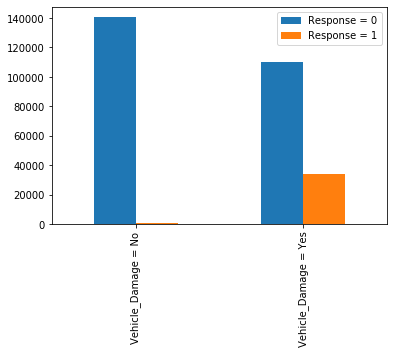

In [15]:
# Response & Previously_Insured
b = pd.DataFrame([[train[(train['Vehicle_Damage'] == 'No') & (train['Response'] == 0)].id.count(), train[(train['Vehicle_Damage'] == 'No') & (train['Response'] == 1)].id.count()],
                  [train[(train['Vehicle_Damage'] == 'Yes') & (train['Response'] == 0)].id.count(), train[(train['Vehicle_Damage'] == 'Yes') & (train['Response'] == 1)].id.count()]],
                 index = ['Vehicle_Damage = No','Vehicle_Damage = Yes'], columns = ['Response = 0','Response = 1'])

print(b)
b.plot.bar()

                      Previously_Insured = 0  Previously_Insured = 1
Vehicle_Damage = No                    17930                  123577
Vehicle_Damage = Yes                  136907                    7417


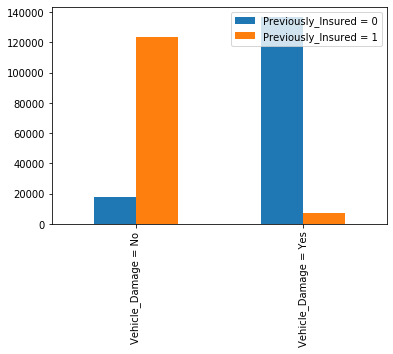

In [16]:
# Previously_Insured & Vehicle_Damage 얘도 한번 보자.

c = pd.DataFrame([[train[(train['Vehicle_Damage'] == 'No') & (train['Previously_Insured'] == 0)].id.count(), train[(train['Vehicle_Damage'] == 'No') & (train['Previously_Insured'] == 1)].id.count()],
                  [train[(train['Vehicle_Damage'] == 'Yes') & (train['Previously_Insured'] == 0)].id.count(), train[(train['Vehicle_Damage'] == 'Yes') & (train['Previously_Insured'] == 1)].id.count()]],
                 index = ['Vehicle_Damage = No','Vehicle_Damage = Yes'], columns = ['Previously_Insured = 0','Previously_Insured = 1'])

print(c)
c.plot.bar()

**위 셋을 통해 알 수 있는 것**
- 이미 자동차 보험이 있는 사람들은 대부분 우리 회사의 자동차 보험에 관심이 없다고 했다. 반면 자동차 보험이 없는 사람들은 상대적으로 우리 회사의 자동차 보험에 관심이 많이 있다. (압도적이라고 봐도 될듯)
- 이전에 사고 이력이 있는 경우가 상대적으로 우리 회사 보험 가입에 관심이 많이 있다.
- 특이하네? 사고이력이 없는 사람이 이미 가입된 보험에 있는 비중이 압도적이고, 사고이력이 있으면 오히려 보험에 가입된게 없네? 
<br>

**셋을 종합해보면**
- 이전에 사고이력이 있는 사람이 우리 회사 자동차 보험에 관심이 상당히 많은데, 이들은 이미 가입된 보험이 없는 경우가 많고, 이미 가입된 보험이 없는 경우 우리 회사의 자동차 보험 가입에 관심이 많다.
- 쉽게 말하면 **1)사고이력 있고, 2)이미 가입된 보험 없는 사람을 노리는게 좋겠다는 소결론을 내려볼 수 있겠다.**

---
**위에서 세웠던 다른 가설들도 더 확인해보자**
- 통계적 검증까지 필요할지, 아니면 시각화를 통해서만 봐도 될지는 우선 시각화해보고 고민해보자.



                     Response = 0  Response = 1
Driving_License = 0           587            32
Driving_License = 1        250212         35000


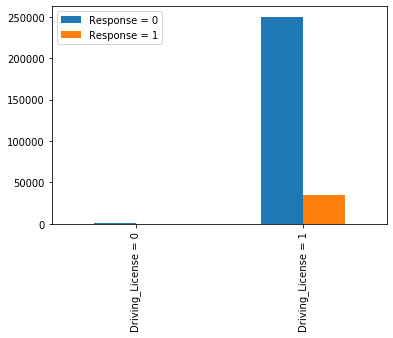

In [17]:
# 운전면허가 없는 고객의 대다수는 자동차 보험에 관심이 없을 것이다.

d = pd.DataFrame([[train[(train['Driving_License'] == 0) & (train['Response'] == 0)].id.count(), train[(train['Driving_License'] == 0) & (train['Response'] == 1)].id.count()],
                  [train[(train['Driving_License'] == 1) & (train['Response'] == 0)].id.count(), train[(train['Driving_License'] == 1) & (train['Response'] == 1)].id.count()]],
                 index = ['Driving_License = 0','Driving_License = 1'], columns = ['Response = 0','Response = 1'])

print(d)
d.plot.bar()

⇒ 큰 의미는 없어 보인다. 

- 면허 있는 고객 중 관심있다고 한 사람 비중이 12.27%라 아까 전체 타겟 클래스 분포랑 다르지 않음.
- 면허가 없는 고객 중 ***32***명이 관심있다 했는데, 왜 그런지 궁금하긴 하지만 내 관심 우선순위는 아님.

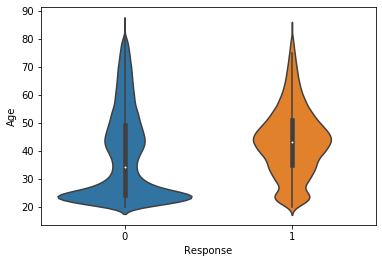

In [18]:
# 나이가 어릴수록 자동차 보험 가입에 관심이 없을 것이다. (보험료를 감당할 수 있는가? 운전에 대한 근거 없는 자신감?)
import seaborn as sns
sns.violinplot(y = train['Age'], x = train['Response'])

(처음에 boxplot으로 봤었는데, 분포 확인이 중요할 것 같아 violinplot으로 다시 그려봤다)

*⇒ 시각화로만 봐서는 관심있다고 한 사람에 대해 30대 이하에서 차이가 보이긴 한다. 젊은 층에서는 확실히 차이가 보이긴 한다.*

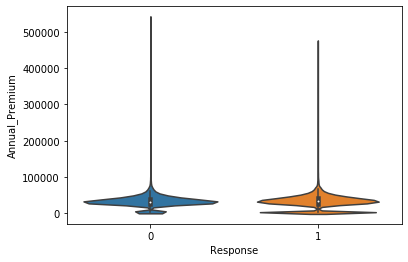

In [19]:
# 연간 보험료가 낮을수록 가입에 관심이 많을 것이다.

sns.violinplot(y = train['Annual_Premium'], x = train['Response'])

=> 뚜렷한 차이 없어보임

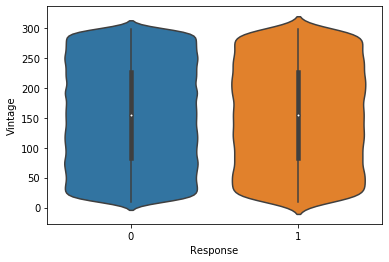

In [20]:
# 고객이 우리 회사와 오래 했을 수록 관심이 많을 것이다.

sns.violinplot(y = train['Vintage'], x = train['Response'])

=> 뚜렷한 차이 없어보임

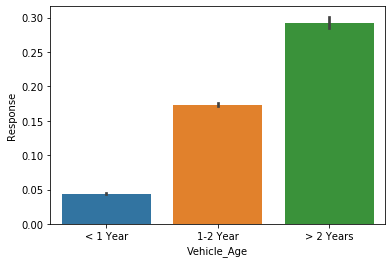

In [21]:
# 자동차 연식이 오래되었을 수록 관심이 없을 것이다.

sns.barplot(x = train['Vehicle_Age'], y = train['Response']) #Response는 mean으로 계산되어 표시됨. train[(train['Vehicle_Age'] == '> 2 Years')].Response.mean()로 확인함.

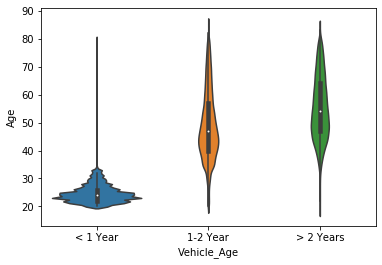

In [22]:
# 그럼 이것도 한번 보자 ⇒ 나이와 자동차 연식의 관계는 어떨까? / 뒤 두 개 질문에 대한 확인으로 봤을 때에는 나이가 어릴 수록 자동차 연식이 얼마 안되었을 가능성이 높음.

sns.violinplot(x = train['Vehicle_Age'], y = train['Age']) 

=> 예상한 것이 맞다.
- 어릴수록 운전경력이 적으니 신차보다는 중고차(=연식이 오래된 차)를 탈 것 같았는데 아니구나나?

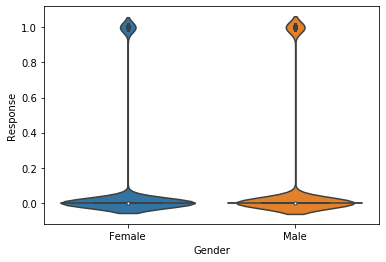

In [23]:
#마지막, 성별과 Response 관계 확인 - 유의미한 차이 없을 것 같음. 
ax = sns.violinplot(x = train['Gender'], y = train['Response']) #이것만 봐선 애매한데,, 
ax = sns.boxplot(x = train['Gender'], y = train['Response']) # 우선 큰 차이는 안 보이는 걸로 결론 내리고 넘어가자.

In [24]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
285701,285702,Female,22,1,2.0,1,< 1 Year,No,32457.0,152.0,98,0
15604,15605,Male,45,1,30.0,1,1-2 Year,No,2630.0,124.0,177,0
10681,10682,Male,27,1,27.0,1,< 1 Year,No,33746.0,152.0,180,0
39611,39612,Male,56,1,36.0,0,1-2 Year,Yes,2630.0,26.0,224,0
42514,42515,Male,23,1,29.0,1,< 1 Year,No,23776.0,152.0,86,0


## Feature Engineering

일단 패스! 

# 3. 모델링 및 모델 해석

In [25]:
#데이터 분리하기1 (train -> train, val)

train_data, val_data = train_test_split(train, stratify = train[target], random_state = 42)
train_data.shape, val_data.shape

((214373, 12), (71458, 12))

In [26]:
#데이터 분리하기2 - feature(X), label(y)

def divide_data(df):
    target = 'Response'

    X = df.drop(columns = target)
    y = df[target]
    
    return X, y

X_train, y_train = divide_data(train) # 교차검증 때 쓸 train only

X_train_data, y_train_data = divide_data(train_data) #train -> train, val로 나눈 것들 
X_val_data, y_val_data = divide_data(val_data)

X_test, y_test = divide_data(test) #테스트 데이터
print(X_train.shape, y_train.shape,'\n', X_train_data.shape, y_train_data.shape, X_val_data.shape, y_val_data.shape,'\n', X_test.shape, y_test.shape)

(285831, 11) (285831,) 
 (214373, 11) (214373,) (71458, 11) (71458,) 
 (95278, 11) (95278,)


## 기준 모델 선정하기
- 단순 타겟 클래스 분포로(최빈값)? 아니면 랜덤포레스트 가장 기본으로? 

In [27]:
# 기준 모델 후보1 - 타겟 클래스 분포 - 최빈값
print(y_train.value_counts(normalize = True))
print(y_train_data.value_counts(normalize = True)) #아 stratify 줘서 비율이 둘이 같구나?

0    0.877438
1    0.122562
Name: Response, dtype: float64
0    0.877438
1    0.122562
Name: Response, dtype: float64


=> 최빈값 기준으로 봐선 최소 87.7%는 넘어야 기본 성능 만족이라고 할 수 있다. 

근데.. 위 최빈값 기준으로 보는 건 결국 Accuracy인데, 지금 데이터셋은 Imbalance하기 때문에 accuracy만 보면 안 된다. 그러면 f1_score도 같이 보는게 좋을 것 같다.

In [28]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
#기준 모델 후보2 - RandomForestClassifier 디폴트, f1-score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.metrics import classification_report



pipe = make_pipeline(
    OneHotEncoder(cols = ['Gender', 'Vehicle_Damage'], use_cat_names = True),
    OrdinalEncoder(),
    RandomForestClassifier(random_state=42, class_weight= 'balanced')
)

pipe.fit(X_train_data, y_train_data)
y_pred_data = pipe.predict(X_val_data)

print(classification_report(y_val_data, y_pred_data))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93     62700
           1       0.41      0.06      0.10      8758

    accuracy                           0.87     71458
   macro avg       0.64      0.52      0.52     71458
weighted avg       0.82      0.87      0.83     71458



In [30]:
from sklearn.metrics import f1_score

f1_score(y_val_data, y_pred_data)

0.1041106798049169

In [31]:
#혹시 test data에 해보면 어떨까?
#y_pred_data2 = pipe.predict(X_test)
#print(classification_report(y_test, y_pred_data2)) #위랑 똑같네..? 이게 맞나?

## 본격적인 모델링 - RandomSearchCV 해보자.

In [32]:

# RandomSearchCV
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from category_encoders import TargetEncoder #OneHotEncoder대신 targetencoder 한 번 써보자! (근데 이렇게 하면 이미 ordinalencoder에서 다 처리될듯?)


pipe = make_pipeline(
    OrdinalEncoder(),
    TargetEncoder(),
    RandomForestClassifier(random_state=42, class_weight= "balanced")
)

dists = {
    'targetencoder__smoothing': [2.,20.,50.,60.,100.,500.,1000.],
    'targetencoder__min_samples_leaf': randint(1, 10),    
    'randomforestclassifier__n_estimators': randint(50, 500), 
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None], 
    #'randomforestclassifier__max_features': uniform(0, 1) # max_features
}

clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=10, 
    cv=3, 
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

#clf.fit(X_train, y_train); 결과 확인 해서 별도로 기록해둠. 

In [33]:
# clf.best_score_ 결과 확인 해서 별도로 기록해둠. 

In [34]:
# clf.best_params_ 결과 확인 해서 별도로 기록해둠. 

In [35]:
'''
결과 확인 해서 별도로 기록해둠. 
pipe = clf.best_estimator_ 
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))
'''

'\n결과 확인 해서 별도로 기록해둠. \npipe = clf.best_estimator_ \ny_pred = pipe.predict(X_test)\nprint(classification_report(y_test, y_pred))\n'

In [36]:
'''
이거 돌려보면 학습 성능 확인할 수 있고,,
clf.best_params_ #탐색결과 찾아낸 최적의 파라미터 값을 확인할 수 있음.
clf.best_score_ # -를 붙인 것은 그 값이 작아질 수록 성능이 좋아지는 걸 뜻하는 score 종류에 붙는다.
clf.cv_results_ #이걸 잘 sort하면 파라미터 조합으로 만들어진 모델들을 순위별로 나열할 수도 있다. 
'''

'\n이거 돌려보면 학습 성능 확인할 수 있고,,\nclf.best_params_ #탐색결과 찾아낸 최적의 파라미터 값을 확인할 수 있음.\nclf.best_score_ # -를 붙인 것은 그 값이 작아질 수록 성능이 좋아지는 걸 뜻하는 score 종류에 붙는다.\nclf.cv_results_ #이걸 잘 sort하면 파라미터 조합으로 만들어진 모델들을 순위별로 나열할 수도 있다. \n'

**[Train, Test 전처리 하고 모델링 다시 해보자]**

- 이유
    - 어제 RandomSearchCV 했던 것 중에 encoder 기준 모델처럼 돌려보려고 했는데 timeout 걸림;
    - Gender, Vehicle_Damage를 원핫인코딩 하고 ordinal encoding 하는 걸로 아예 적용한 다음에 모델 다시 한번 돌려보자.
- 기준 모델 돌렸을 때 처럼 원핫인코딩, ordinal인코딩 전처리 ⇒ 똑같이 랜덤CV 돌려서 스코어 보기
    - 주의! train에 fit_transform하고 test에는 transform만 하기!

In [37]:
##훈련 데이터

#Onehot
encoder = OneHotEncoder(cols = ['Gender', 'Vehicle_Damage'], use_cat_names = True)
X_train_enc = encoder.fit_transform(X_train)

#ordinal - Vehicle Age 때문에 해주는 거임.
encoder2 = OrdinalEncoder()
X_train_enc = encoder2.fit_transform(X_train_enc)
X_train_enc.head()

,id,Gender_Female,Gender_Male,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage_No,Vehicle_Damage_Yes,Annual_Premium,Policy_Sales_Channel,Vintage
285701,285702,1,0,22,1,2.0,1,1,1,0,32457.0,152.0,98
15604,15605,0,1,45,1,30.0,1,2,1,0,2630.0,124.0,177
10681,10682,0,1,27,1,27.0,1,1,1,0,33746.0,152.0,180
39611,39612,0,1,56,1,36.0,0,2,0,1,2630.0,26.0,224
42514,42515,0,1,23,1,29.0,1,1,1,0,23776.0,152.0,86


In [38]:
# 테스트 데이터 적용
X_test_enc = encoder.transform(X_test)
X_test_enc = encoder2.transform(X_test_enc)
X_test_enc.head()

,id,Gender_Female,Gender_Male,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage_No,Vehicle_Damage_Yes,Annual_Premium,Policy_Sales_Channel,Vintage
327587,327588,1,0,49,1,48.0,0,2,0,1,2630.0,26.0,277
317216,317217,0,1,38,1,9.0,0,2,0,1,31136.0,154.0,172
142753,142754,0,1,41,1,41.0,1,2,1,0,30748.0,124.0,19
259950,259951,1,0,23,1,8.0,1,1,1,0,42775.0,152.0,191
39287,39288,0,1,25,1,14.0,1,1,1,0,23938.0,152.0,201


위에 했던 랜덤서치CV 똑같이 한번 더 돌려보자.

In [39]:
pipe = make_pipeline(
    RandomForestClassifier(n_jobs= -1,random_state=42, class_weight= "balanced")
)

dists = {
    'randomforestclassifier__n_estimators': randint(50, 500), 
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None], 
    #'randomforestclassifier__max_features': uniform(0, 1) # max_features
}

clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=10, 
    cv=3, 
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

#clf.fit(X_train_enc, y_train)

In [40]:
#clf.best_score_ #0.44499202272212984

In [41]:
'''
pipe = clf.best_estimator_ 
y_pred = pipe.predict(X_test_enc)
print(classification_report(y_test, y_pred)) #f1 = 0.45
'''

'\npipe = clf.best_estimator_ \ny_pred = pipe.predict(X_test_enc)\nprint(classification_report(y_test, y_pred)) #f1 = 0.45\n'

## 특성 공학 한번 해보자

In [42]:
#`Policy_Sales_Channel` - 원핫인코딩하면 카니럴리티도 높게 나올 것 같고, 분포 봤을 때도 딱히 의미있는 정보는 아닐 것 같다.
# 'id'도 날려보자. 

cols = ['id','Policy_Sales_Channel']

train_drop = train.drop(columns = cols)
test_drop = test.drop(columns = cols)
train_drop.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Vintage,Response
285701,Female,22,1,2.0,1,< 1 Year,No,32457.0,98,0
15604,Male,45,1,30.0,1,1-2 Year,No,2630.0,177,0
10681,Male,27,1,27.0,1,< 1 Year,No,33746.0,180,0
39611,Male,56,1,36.0,0,1-2 Year,Yes,2630.0,224,0
42514,Male,23,1,29.0,1,< 1 Year,No,23776.0,86,0


In [43]:
#reset_index1

train_drop = train_drop.reset_index()
train_drop = train_drop.drop(columns = 'index')
train_drop.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Vintage,Response
0,Female,22,1,2.0,1,< 1 Year,No,32457.0,98,0
1,Male,45,1,30.0,1,1-2 Year,No,2630.0,177,0
2,Male,27,1,27.0,1,< 1 Year,No,33746.0,180,0
3,Male,56,1,36.0,0,1-2 Year,Yes,2630.0,224,0
4,Male,23,1,29.0,1,< 1 Year,No,23776.0,86,0


In [44]:
#reset_index1

test_drop = test_drop.reset_index()
test_drop = test_drop.drop(columns = 'index')
test_drop.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Vintage,Response
0,Female,49,1,48.0,0,1-2 Year,Yes,2630.0,277,1
1,Male,38,1,9.0,0,1-2 Year,Yes,31136.0,172,1
2,Male,41,1,41.0,1,1-2 Year,No,30748.0,19,0
3,Female,23,1,8.0,1,< 1 Year,No,42775.0,191,0
4,Male,25,1,14.0,1,< 1 Year,No,23938.0,201,0


In [45]:
#데이터 나누기

X_train_drop, y_train_drop = divide_data(train_drop)
X_test_drop, y_test_drop = divide_data(test_drop)

In [46]:
#인코딩 했던거 다시 적용해보자.

#Onehot
X_train_drop = encoder.fit_transform(X_train_drop)

#ordinal - Vehicle Age 때문에 해주는 거임.
X_train_drop = encoder2.fit_transform(X_train_drop)
X_train_drop.head()


,Gender_Female,Gender_Male,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage_No,Vehicle_Damage_Yes,Annual_Premium,Vintage
0,1,0,22,1,2.0,1,1,1,0,32457.0,98
1,0,1,45,1,30.0,1,2,1,0,2630.0,177
2,0,1,27,1,27.0,1,1,1,0,33746.0,180
3,0,1,56,1,36.0,0,2,0,1,2630.0,224
4,0,1,23,1,29.0,1,1,1,0,23776.0,86


In [47]:
# 테스트 데이터 적용
X_test_drop = encoder.transform(X_test_drop)
X_test_drop = encoder2.transform(X_test_drop)
X_test_drop.head()

,Gender_Female,Gender_Male,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage_No,Vehicle_Damage_Yes,Annual_Premium,Vintage
0,1,0,49,1,48.0,0,2,0,1,2630.0,277
1,0,1,38,1,9.0,0,2,0,1,31136.0,172
2,0,1,41,1,41.0,1,2,1,0,30748.0,19
3,1,0,23,1,8.0,1,1,1,0,42775.0,191
4,0,1,25,1,14.0,1,1,1,0,23938.0,201


In [48]:
#아까 만든 모델에 한번 돌려볼까?
#clf.fit(X_train_drop, y_train)


In [49]:
#best score 확인! 

#clf.best_score_ 0.4374259887597291

In [50]:
#기준 모델(인코딩 제외) 다시 돌려보자 - train, test만 - 처음이랑 달라진게 있는지 보고 싶음.
pipe = make_pipeline(
    RandomForestClassifier(random_state=42, class_weight= 'balanced')
)

#pipe.fit(X_train_drop, y_train)
#y_pred_data = pipe.predict(X_test_drop)

#print(classification_report(y_test, y_pred_data)) 0.17

## [모델 최대한 기본으로 여러 종류 돌려보고 가장 나은 걸 고도화해보자]
특성공학은 우선 `id`만 날린다.

### 데이터 재준비

In [51]:
train, test = train_test_split(df, stratify = df[target], random_state = 42) # stratify를 target에 맞추어서! 

In [52]:
# 데이터 준비
drop = 'id'

train = train.drop(columns = drop)
test = test.drop(columns = drop)

In [53]:
#reset_index

train = train.reset_index()
test = test.reset_index()

train = train.drop(columns = 'index')
test = test.drop(columns = 'index')

In [54]:
#(맨 뒤에서 다시 돌아옴) - Vehicle_Damage 직접 변경

train['Vehicle_Damage'] = train['Vehicle_Damage'].replace('No', 0)
train['Vehicle_Damage'] = train['Vehicle_Damage'].replace('Yes', 1)

test['Vehicle_Damage'] = test['Vehicle_Damage'].replace('No', 0)
test['Vehicle_Damage'] = test['Vehicle_Damage'].replace('Yes', 1)

In [55]:
#인코딩

encoder1 = OneHotEncoder(cols = ['Gender'], use_cat_names = True)

train = encoder1.fit_transform(train)
train = encoder2.fit_transform(train)

test = encoder1.transform(test)
test = encoder2.transform(test)

In [56]:
test.head()

,Gender_Female,Gender_Male,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,0,49,1,48.0,0,2,1,2630.0,26.0,277,1
1,0,1,38,1,9.0,0,2,1,31136.0,154.0,172,1
2,0,1,41,1,41.0,1,2,0,30748.0,124.0,19,0
3,1,0,23,1,8.0,1,1,0,42775.0,152.0,191,0
4,0,1,25,1,14.0,1,1,0,23938.0,152.0,201,0


In [57]:
#데이터 분리

X_train, y_train = divide_data(train)
X_test, y_test = divide_data(test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(285831, 11) (285831,)
(95278, 11) (95278,)


### 여러 모델 만들어보기

In [58]:
# RandomSearchCV 이것 저것
pipe = make_pipeline(RandomForestClassifier(random_state=42))

dists = {
    'randomforestclassifier__n_estimators': randint(50, 500), 
    'randomforestclassifier__max_depth': [10, 20, 50],
    'randomforestclassifier__class_weight': ['balanced', None],
    'randomforestclassifier__min_samples_leaf': randint(1,20)
    #'randomforestclassifier__max_features': uniform(0, 1) # max_features
}

clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=15, 
    cv=5, 
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

#clf.fit(X_train, y_train);

In [59]:
#clf.best_params_
#clf.best_score_ 

In [60]:
'''
pipe = clf.best_estimator_
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))
'''

'\npipe = clf.best_estimator_\ny_pred = pipe.predict(X_test)\nprint(classification_report(y_test, y_pred))\n'

In [61]:
#GridSearchCV
from sklearn.model_selection import GridSearchCV

params = { 'n_estimators' : [50, 100, 200, 300, 400],
           'max_depth' : [5, 10, 20, 50],
            }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 42, n_jobs = -1, class_weight = 'balanced')
grid_cv = GridSearchCV(rf_clf, param_grid = params, scoring = 'f1', cv = 5, n_jobs = -1)
#grid_cv.fit(X_train, y_train)

#print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
#print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

In [62]:
'''
f_clf1 = RandomForestClassifier(n_estimators = 400, 
                                max_depth = 20,
                                random_state = 42,
                                n_jobs = -1)
rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)
print(classification_report(y_test,pred))
'''

'\nf_clf1 = RandomForestClassifier(n_estimators = 400, \n                                max_depth = 20,\n                                random_state = 42,\n                                n_jobs = -1)\nrf_clf1.fit(X_train, y_train)\npred = rf_clf1.predict(X_test)\nprint(classification_report(y_test,pred))\n'

In [63]:
#XGboost
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

model = XGBClassifier(n_estimators= 200, random_state = 42, n_jobs = -1, max_depth = 8, learning_rate = 0.1, scale_pos_weight = 4)

eval_set = [(X_train, y_train),
            (X_test, y_test)]

#model.fit(X_train, y_train, eval_set = eval_set, early_stopping_rounds = 50)

In [64]:
'''
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
'''

'\ny_pred = model.predict(X_test)\nprint(classification_report(y_test, y_pred))\n'

In [65]:
# 다운 샘플링 해보자! 
zero_train = train[train[target] == 0]
one_train = train[train[target] == 1]

zero_train.shape, one_train.shape

((250799, 12), (35032, 12))

In [66]:
from sklearn.utils import resample 
zero_train_downsample = resample(
    zero_train,
    replace = True,
    n_samples = len(one_train),
    random_state = 42
)

zero_train_downsample.shape # label이 0인 것 1 숫자에 맞춰 다운샘플링 함.

(35032, 12)

In [67]:
#다운샘플링 한 데이터와 합치기

train_down_sample = pd.concat([zero_train_downsample, one_train])

train_down_sample[target].value_counts(normalize = True) #비율 동일하게 맞춰졌다. 

0    0.5
1    0.5
Name: Response, dtype: float64

In [68]:
#데이터 분리

X_train_downsample, y_train_downsample = divide_data(train_down_sample)
X_train_downsample.shape, y_train_downsample.shape

((70064, 11), (70064,))

In [69]:
#간단하게 XGBoost 돌려볼까?

model = XGBClassifier(n_estimators= 200, random_state = 42, n_jobs = -1, max_depth = 8, learning_rate = 0.1, scale_pos_weight = 0)

eval_set = [(X_train_downsample, y_train_downsample),
            (X_test, y_test)]

#model.fit(X_train_downsample, y_train_downsample, eval_set = eval_set, early_stopping_rounds = 50)

In [70]:
#y_pred = model.predict(X_test)
#print(classification_report(y_test, y_pred))

In [71]:
X_train_downsample2 = X_train_downsample.drop(columns = 'Policy_Sales_Channel')
X_test2 = X_test.drop(columns = 'Policy_Sales_Channel')

In [72]:
X_train_downsample2 = X_train_downsample.drop(columns = 'Annual_Premium')
X_test2 = X_test.drop(columns = 'Annual_Premium')

In [73]:
#이상하게 나오네; randomsearchcv 돌려보자.

pipe = make_pipeline(RandomForestClassifier(random_state=42))

dists = {
    'randomforestclassifier__n_estimators': randint(100, 500), 
    'randomforestclassifier__max_depth': [10, 20, 50],
    'randomforestclassifier__min_samples_split': randint(10, 50),
    'randomforestclassifier__min_samples_leaf': randint(1,20),
    #'randomforestclassifier__max_features': uniform(0, 0.5) 
}

clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=10, 
    cv=3, 
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train_downsample2, y_train_downsample);

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [74]:
clf.best_params_

{'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__min_samples_leaf': 5,
 'randomforestclassifier__min_samples_split': 16,
 'randomforestclassifier__n_estimators': 485}

In [75]:
clf.best_score_ 

0.8205573194838455

In [76]:
pipe = clf.best_estimator_
y_pred = pipe.predict(X_test2)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.66      0.79     83600
           1       0.28      0.94      0.43     11678

    accuracy                           0.69     95278
   macro avg       0.63      0.80      0.61     95278
weighted avg       0.90      0.69      0.74     95278



# 모델 해석

In [77]:
!pip install eli5
!pip install pdpbox
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [78]:
#PermutationImportance
import eli5
from eli5.sklearn import PermutationImportance

model = pipe # best_estimator_

permuter = PermutationImportance(
        model,
        scoring = 'f1',
        n_iter = 5,
        random_state = 42
    )

#permuter.fit(X_test2, y_test);

KeyboardInterrupt: ignored

In [ ]:
#feature_names = X_test2.columns.tolist()
#pd.Series(permuter.feature_importances_, feature_names).sort_values()

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f850cb0da10>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f850cb0d1d0>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


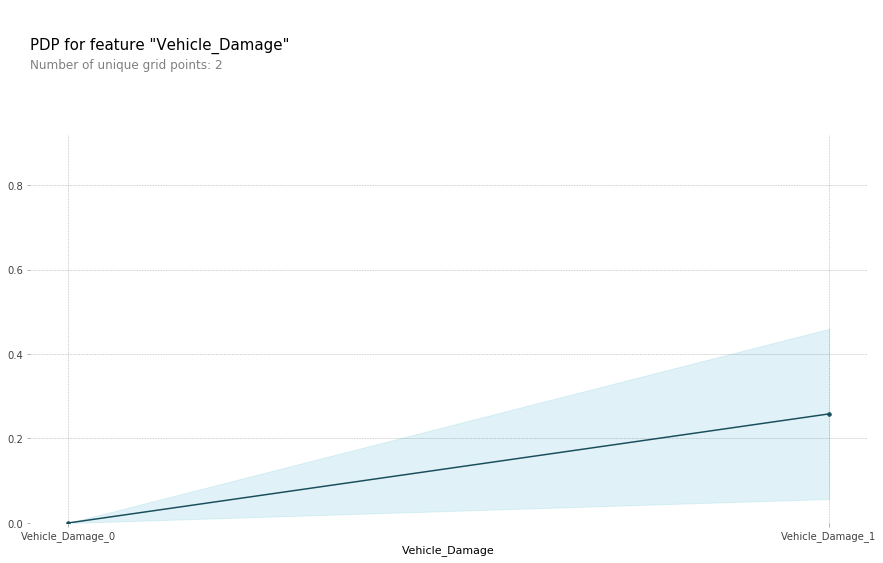

In [79]:
#pdp

from pdpbox.pdp import pdp_isolate, pdp_plot


def get_pdp_isolated(dataset, model, feature):
    pdp_isolated = None

    # YOUR CODE HERE
    feature = feature 
    pdp_isolated = pdp_isolate(
        model = model,
        dataset = dataset,
        model_features = dataset.columns,
        feature = feature,
        grid_type = 'percentile',
        num_grid_points = 10
    )
    
    # YOUR CODE ENDS HERE

    return pdp_isolated

feature = 'Vehicle_Damage'
pdp_isolated = get_pdp_isolated(X_test2, model, feature)
pdp_plot(pdp_isolated, feature_name=feature)

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f850c82b410>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f850c86cbd0>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


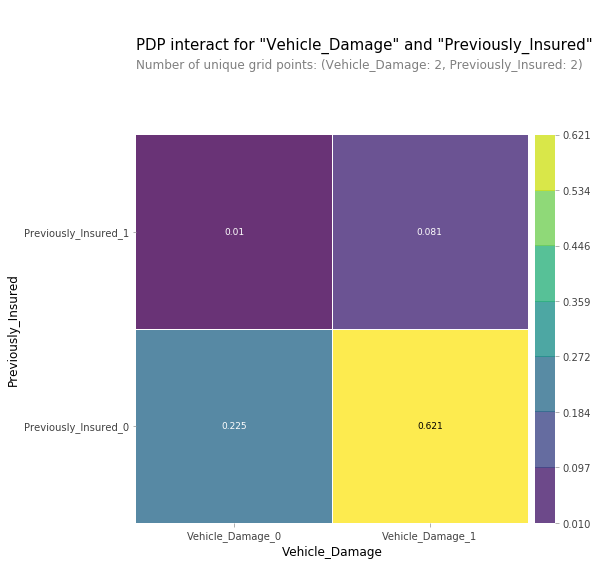

In [81]:
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
features = ['Vehicle_Damage', 'Previously_Insured']
interaction = pdp_interact(
    model = model,
    dataset = X_test2,
    model_features = X_test2.columns,
    features = features
)

pdp_interact_plot(interaction, feature_names = features, plot_type = 'grid')